<a href="https://colab.research.google.com/github/roulupen/EVAAssignments/blob/master/Assignment14/Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Assignment - 14***

1.   Move the data to TFRecords
2.   Add CutOut
3.   Show your training logs, training graphs (including validation), and final accuracy

***Team Member***:

*   Upendra Roul
*   Amit Doda



In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE =  128#@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS =  24#@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.drop = tf.keras.layers.Dropout(0.1)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.drop(self.conv(inputs))))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [8]:
import os
import sys
from random import shuffle
import glob
import cv2
import numpy as np
import tensorflow as tf
from google.colab import drive
from keras.datasets import cifar10, mnist

class Dataset(object):

    data_path: str

    def __init__(self):
        drive.mount('../content/drive/', force_remount=True)
        os.listdir('../content/drive/My Drive/datasets/')
        self.data_path = '../content/drive/My Drive/datasets/'

    def __int64_feature(self, value) -> tf.train.Feature:
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def __bytes_feature(self, value) -> tf.train.Feature:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def __load_image(self, addr):
        # read an image and resize to (224, 224)
        # cv2 load images as BGR, convert it to RGB
        img = cv2.imread(addr)
        if img is None:
            return None
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def __normalize(self, data_set, padding: bool = False):

        # Null check
        if data_set is None:
            return None

        mean = np.mean(data_set, axis=(0, 1, 2))
        std = np.std(data_set, axis=(0, 1, 2))
        normalize_data = lambda x: ((x - mean) / std).astype('float32')
        pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

        if padding:
            data_set = pad4(data_set)

        return normalize_data(data_set)

    def input_fn(self, file_names, batch_size: int, buffer_size: int = 1024, is_train_file = True):

        def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
            inp_shape = tf.shape(input_)
            size = tf.shape(replacement)
            padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
            replacement_pad = tf.pad(replacement, padding)
            mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
            return tf.where(mask, replacement_pad, input_)

        def cutout(x: tf.Tensor, h: int, w: int, c: int = 3) -> tf.Tensor:
            """
            Cutout data augmentation. Randomly cuts a h by w whole in the image, and fill the whole with zeros.

            :param x: Input image.
            :param h: Height of the hole.
            :param w: Width of the hole
            :param c: Number of color channels in the image. Default: 3 (RGB).
            :return: Transformed image.
            """
            shape = tf.shape(x)
            x0 = tf.random.uniform([], 0, shape[0] + 1 - h, dtype=tf.int32)
            y0 = tf.random.uniform([], 0, shape[1] + 1 - w, dtype=tf.int32)
            x = replace_slice(x, tf.zeros([h, w, c]), [x0, y0, 0])
            return x

        def parser(record, is_train):
            keys_to_features = {
                "image_raw": tf.FixedLenFeature([], tf.string),
                "label": tf.FixedLenFeature([], tf.int64)
            }
            parsed = tf.parse_single_example(record, keys_to_features)
            image = tf.decode_raw(parsed["image_raw"], tf.float32)
            label = tf.cast(parsed["label"], tf.int64)
            image = tf.reshape(image, [32, 32, 3])

            # Random crop and random flip from left to right in case of training images
            if is_train:
                image = tf.image.random_flip_left_right(tf.random_crop(image, [32, 32, 3]))
                image = cutout(image, 10, 10)

            return image, label

        tfrecord_dataset = tf.data.TFRecordDataset(filenames=file_names, num_parallel_reads=40)
        tfrecord_dataset = tfrecord_dataset.map(lambda x: parser(x, is_train_file)).shuffle(True).batch(batch_size)
  
        tfrecord_iterator = tfrecord_dataset.make_one_shot_iterator()
        return tfrecord_iterator

    def create_data_record(self, out_filename, addrs, labels, is_image: bool = False):
        # open the TFRecords file
        writer = tf.python_io.TFRecordWriter(out_filename)

        for i in range(len(addrs)):
            # print how many images are saved every 1000 images
            if not i % 1000:
                print('{} data: {}/{}'.format(out_filename, i, len(addrs)))
                sys.stdout.flush()

            # Load the image
            if is_image:
                img = addrs[i]
            else:
                img = self.__load_image(addrs[i])

            if img is None:
                continue

            label = labels[i]

            # Create a feature
            feature = {
                'image_raw': self.__bytes_feature(img.tostring()),
                'label': self.__int64_feature(label)
            }
            # Create an example protocol buffer
            example = tf.train.Example(features=tf.train.Features(feature=feature))

            # Serialize to string and write on the file
            writer.write(example.SerializeToString())

        writer.close()
        sys.stdout.flush()

    def get_record_count(self, file_name):
        return sum(1 for _ in tf.python_io.tf_record_iterator(file_name))

    def get_tf_records(self, data_set_name):

        if data_set_name is None:
            return

        train_file_path = self.data_path + data_set_name + '.train.tfrecords'
        test_file_path = self.data_path + data_set_name + '.test.tfrecords'

        if 'cifar10' in data_set_name:
            if not os.path.exists(train_file_path) or not os.path.exists(test_file_path):
                (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
                self.create_data_record(train_file_path, self.__normalize(train_features), train_labels, True)
                self.create_data_record(test_file_path, self.__normalize(test_features), test_labels, True)
        elif 'mnist' in data_set_name:
            if not os.path.exists(train_file_path) or not os.path.exists(test_file_path):
                (train_features, train_labels), (test_features, test_labels) = mnist.load_data()
                self.create_data_record(train_file_path, self.__normalize(train_features), train_labels, True)
                self.create_data_record(test_file_path, self.__normalize(test_features), test_labels, True)
        else:
            raise Exception("The data set {} is not supported.".format(data_set_name))

        return train_file_path, test_file_path

Using TensorFlow backend.


In [9]:
data_set = Dataset()
train_file_path, test_file_path = data_set.get_tf_records('cifar10')
print(train_file_path, test_file_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ../content/drive/
../content/drive/My Drive/datasets/cifar10.train.tfrecords ../content/drive/My Drive/datasets/cifar10.test.tfrecords


In [10]:
len_train = data_set.get_record_count(train_file_path)
len_test= data_set.get_record_count(test_file_path)

model = DavidNet()
global_step = None
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [11]:
t = time.time()

# Keep results for plotting
train_loss_results = []
test_loss_results = []
train_accuracy_results = []
test_accuracy_results = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = data_set.input_fn(train_file_path, BATCH_SIZE)
  
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()
  
  tf.keras.backend.set_learning_phase(0)
  test_set = data_set.input_fn(file_names = test_file_path, batch_size = BATCH_SIZE, is_train_file = False)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  train_loss_results.append(train_loss / len_train)
  test_loss_results.append(test_loss / len_test)

  train_accuracy_results.append(train_acc / len_train)
  test_accuracy_results.append(test_acc / len_test)
  
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.



epoch: 1 lr: 0.08 train loss: 1.3724182652282715 train acc: 0.50302 val loss: 1.1184105913162232 val acc: 0.5984 time: 79.99003219604492



epoch: 2 lr: 0.16 train loss: 0.8570883177185059 train acc: 0.69956 val loss: 0.8708646907806397 val acc: 0.704 time: 143.48336720466614



epoch: 3 lr: 0.24 train loss: 0.7158972298431396 train acc: 0.75316 val loss: 0.7236632009506225 val acc: 0.7675 time: 207.4508237838745



epoch: 4 lr: 0.32 train loss: 0.6173681398010253 train acc: 0.78518 val loss: 0.648199762058258 val acc: 0.7826 time: 270.5217230319977



epoch: 5 lr: 0.4 train loss: 0.5430338538360596 train acc: 0.81308 val loss: 0.47620105295181275 val acc: 0.8429 time: 333.7373914718628



epoch: 6 lr: 0.37894736842105264 train loss: 0.47025648197174075 train acc: 0.8366 val loss: 0.5103149722099304 val acc: 0.8302 time: 397.73738980293274



epoch: 7 lr: 0.35789473684210527 train loss: 0.4019404364013672 train acc: 0.86228 val loss: 0.4137446389198303 val acc: 0.8614 time: 461.0054576396942



epoch: 8 lr: 0.33684210526315794 train loss: 0.3460623025894165 train acc: 0.88118 val loss: 0.3926746202945709 val acc: 0.8702 time: 524.6813259124756



epoch: 9 lr: 0.31578947368421056 train loss: 0.30374848133087157 train acc: 0.8934 val loss: 0.40205509586334226 val acc: 0.8685 time: 587.4541594982147



epoch: 10 lr: 0.2947368421052632 train loss: 0.2723335106277466 train acc: 0.90496 val loss: 0.3394499666213989 val acc: 0.8838 time: 650.1936950683594



epoch: 11 lr: 0.2736842105263158 train loss: 0.23733326622009276 train acc: 0.91602 val loss: 0.3462239278316498 val acc: 0.8845 time: 713.0733263492584



epoch: 12 lr: 0.25263157894736843 train loss: 0.20804243734359743 train acc: 0.9266 val loss: 0.33687206020355226 val acc: 0.8925 time: 775.3983545303345



epoch: 13 lr: 0.23157894736842108 train loss: 0.17938907358169556 train acc: 0.93656 val loss: 0.3238481191635132 val acc: 0.8974 time: 838.0274641513824



epoch: 14 lr: 0.2105263157894737 train loss: 0.15559766620635987 train acc: 0.9456 val loss: 0.32607460899353025 val acc: 0.9003 time: 900.2513408660889



epoch: 15 lr: 0.18947368421052635 train loss: 0.13409012986183166 train acc: 0.95246 val loss: 0.3571973330974579 val acc: 0.8946 time: 962.2011125087738



epoch: 16 lr: 0.16842105263157897 train loss: 0.11411506819725037 train acc: 0.95988 val loss: 0.3275700048923492 val acc: 0.9029 time: 1024.6079759597778



epoch: 17 lr: 0.1473684210526316 train loss: 0.10774463189601899 train acc: 0.96206 val loss: 0.3403097728729248 val acc: 0.9022 time: 1086.5396103858948



epoch: 18 lr: 0.12631578947368421 train loss: 0.08598638826847077 train acc: 0.97096 val loss: 0.30647595047950743 val acc: 0.9124 time: 1149.0689435005188



epoch: 19 lr: 0.10526315789473689 train loss: 0.07450107663631439 train acc: 0.97448 val loss: 0.3085015914916992 val acc: 0.9114 time: 1210.8039100170135



epoch: 20 lr: 0.08421052631578951 train loss: 0.058529239239692686 train acc: 0.98032 val loss: 0.3043251766681671 val acc: 0.913 time: 1273.5242195129395



epoch: 21 lr: 0.06315789473684214 train loss: 0.052287634270191195 train acc: 0.98262 val loss: 0.30677011675834653 val acc: 0.9141 time: 1336.585208415985



epoch: 22 lr: 0.04210526315789476 train loss: 0.04473850562810898 train acc: 0.98516 val loss: 0.30114028210639954 val acc: 0.9151 time: 1399.0522978305817



epoch: 23 lr: 0.02105263157894738 train loss: 0.03848622258245945 train acc: 0.98764 val loss: 0.2920276977300644 val acc: 0.916 time: 1461.5786690711975



epoch: 24 lr: 0.0 train loss: 0.03291034442543984 train acc: 0.98946 val loss: 0.2915070272684097 val acc: 0.9183 time: 1523.6913752555847


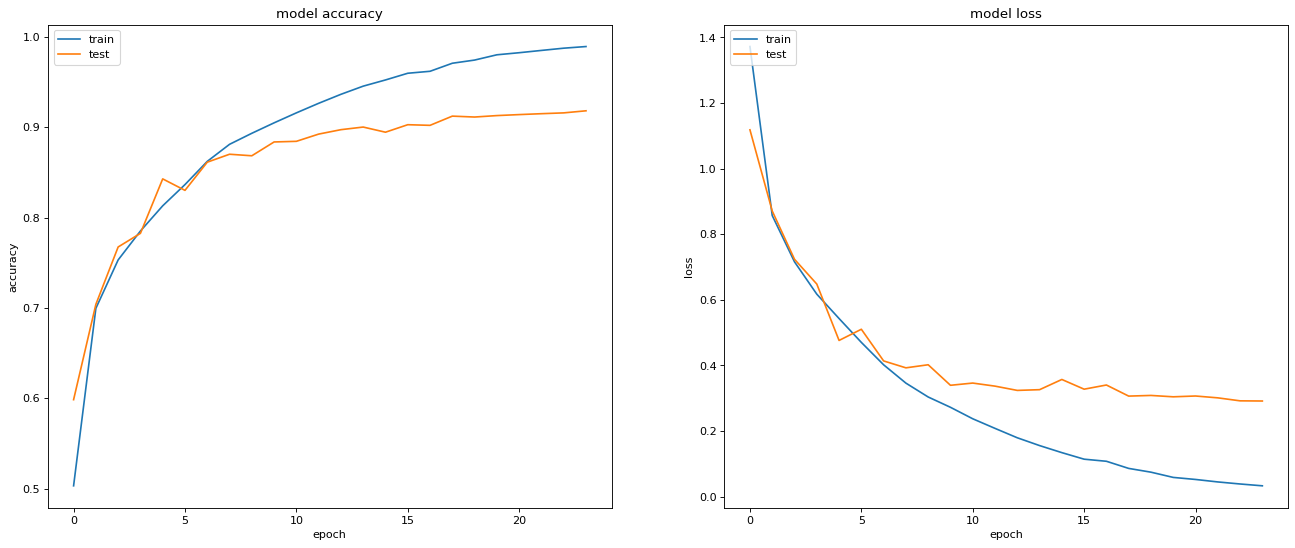

Best accuracy: 0.9183


In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_results)
plt.plot(test_accuracy_results)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_results)
plt.plot(test_loss_results)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Best accuracy: {}'.format(np.amax(test_accuracy_results)))